In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from tqdm import tqdm

from PIL import Image

import matplotlib.pyplot as plt

import torch
from torch import Tensor
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from src.models.resnet import ResNet

In [35]:
train_data_path = r'..\\dataset\\train'
test_data_path = r'..\\dataset\\test'

(300, 300)


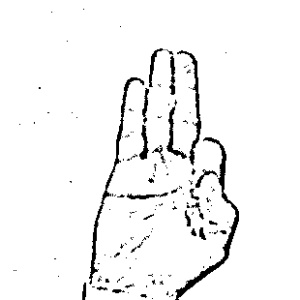

In [ ]:
image = Image.open(os.path.join(train_data_path, 'F\\10.jpg'))
print(image.size)
image

In [36]:
labels = os.listdir(train_data_path)
numeric_labels = {label: idx for idx, label in enumerate(labels)}
reverse_numeric_labels = {idx: label for label, idx in numeric_labels.items()}
print(numeric_labels)
print(reverse_numeric_labels)

{'0': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26}
{0: '0', 1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E', 6: 'F', 7: 'G', 8: 'H', 9: 'I', 10: 'J', 11: 'K', 12: 'L', 13: 'M', 14: 'N', 15: 'O', 16: 'P', 17: 'Q', 18: 'R', 19: 'S', 20: 'T', 21: 'U', 22: 'V', 23: 'W', 24: 'X', 25: 'Y', 26: 'Z'}


In [37]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.947], std=[0.177])
])

train_dataset = datasets.ImageFolder(root=train_data_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_data_path, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [38]:
batch_images, batch_labels = next(iter(train_dataloader))
print(f'training data shape: images -> {batch_images.shape}, labels -> {batch_labels.shape}')

training data shape: images -> torch.Size([64, 1, 128, 128]), labels -> torch.Size([64])


In [42]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [43]:
model = ResNet(in_channels=1).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
loss_fn = nn.CrossEntropyLoss()

In [47]:
train_losses = []
test_losses = []
test_accuracies = []

epochs = 3

for epoch in tqdm(range(epochs)):
    # Training phase
    model.train()
    epoch_loss = 0
    num_train_batches = len(train_dataloader)

    for i, (img, label) in enumerate(train_dataloader):
        img, label = img.to(device), label.to(device)

        logits = model(img)
        loss: Tensor = loss_fn(logits, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / num_train_batches
    train_losses.append(avg_train_loss)

    # Test phase (eval phase)
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    num_test_batches = len(test_dataloader)

    with torch.no_grad():
        for img, label in test_dataloader:
            img, label = img.to(device), label.to(device)

            logits = model(img)
            loss: Tensor = loss_fn(logits, label)
            test_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(logits, 1)
            correct += (predicted == label).sum().item()
            total += label.size(0)

    avg_test_loss = test_loss / num_test_batches
    test_accuracy = correct / total * 100
    test_losses.append(avg_test_loss)
    
    test_accuracies.append(test_accuracy)
    print(f'Epoch {epoch+1}/{epochs} - Avg Train Loss: {avg_train_loss:.4f}')
    print(f'Epoch {epoch+1}/{epochs} - Avg Test Loss: {avg_test_loss:.4f}, Accuracy: {test_accuracy:.2f}%')

 33%|███▎      | 1/3 [11:53<23:46, 713.20s/it]

Epoch 1/3 - Avg Train Loss: 0.0336
Epoch 1/3 - Avg Test Loss: 0.7865, Accuracy: 82.86%


 67%|██████▋   | 2/3 [14:53<06:39, 399.89s/it]

Epoch 2/3 - Avg Train Loss: 0.0255
Epoch 2/3 - Avg Test Loss: 0.3682, Accuracy: 91.63%


100%|██████████| 3/3 [18:20<00:00, 366.88s/it]

Epoch 3/3 - Avg Train Loss: 0.0219
Epoch 3/3 - Avg Test Loss: 0.4194, Accuracy: 92.81%


In [48]:
torch.save(model.state_dict(), '..\\weights\\asl_model_weights.pth')

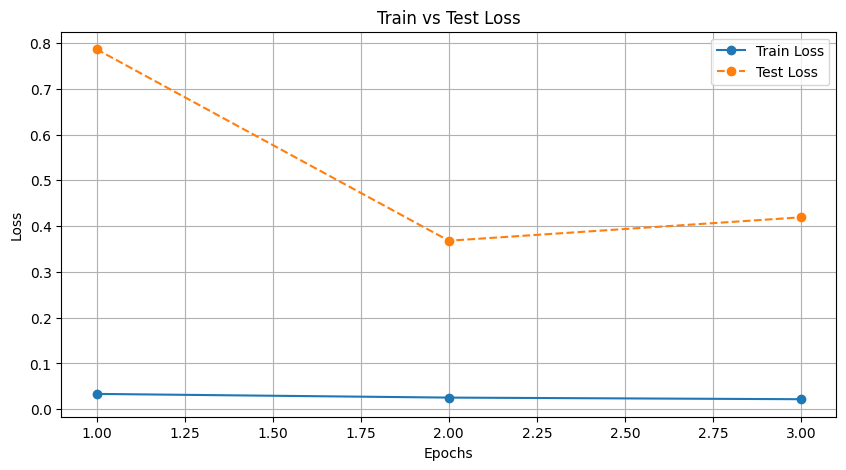

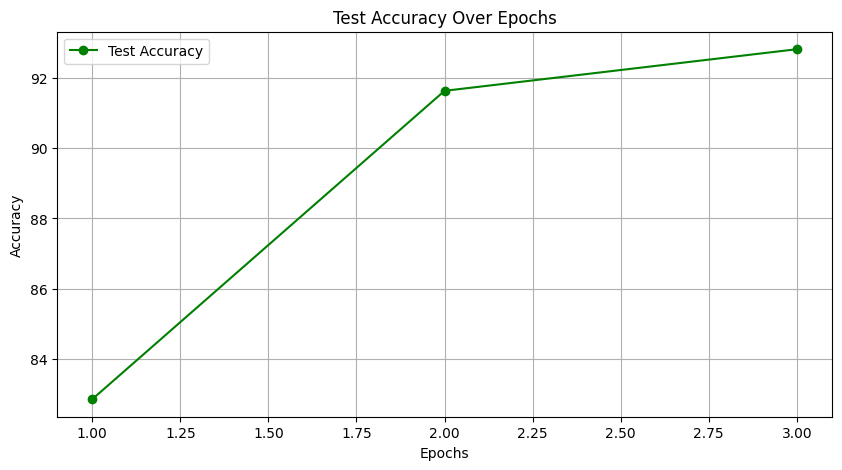

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, epochs+1), test_losses, label="Test Loss", marker="o", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Test Loss")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), test_accuracies, label="Test Accuracy", marker="o", color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Test Accuracy Over Epochs")
plt.legend()
plt.grid()
plt.show()